In [1]:
import torax.constants
from torax.config.config_loader import build_sim_and_runtime_params_from_config_module
from torax.simulation_app import main
from torax.output import load_state_file
from torax import set_jax_precision
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import chex

keV2J = torax.constants.CONSTANTS.keV2J

set_jax_precision()

In [2]:
sim, runtime_params = build_sim_and_runtime_params_from_config_module('torax.examples.strange_solution', None)
output_file = main(
    lambda: sim,
    log_sim_progress=True,
    plot_sim_progress=False,
    log_sim_output=False,
)

2025-02-11 15:53:51,865 [    INFO] 
          Config input Zeff not directly defined at rhonorm=1.0.
          Zeff_face at rhonorm=1.0 set from constant values or constant extrapolation.
          
2025-02-11 15:53:51,866 [    INFO] 
          Config input Zeff not directly defined at rhonorm=1.0.
          Zeff_face at rhonorm=1.0 set from constant values or constant extrapolation.
          
INFO:2025-02-11 15:53:51,932:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-11 15:53:51,932 [    INFO] Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-02-11 15:53:51,937:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-02-11 15:53:51,937 [    INFO] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: l

The equation TORAX solves for density is:
$$
\left(\frac{\partial}{\partial t}-\frac{\dot{\Phi}_b}{2\Phi_b}\frac{\partial}{\partial \hat\rho}\hat\rho\right)\left[n_eV'\right] = \frac{\partial}{\partial\hat\rho}\left[D_e\frac{g_1}{V'}\frac{\partial n_e}{\partial\hat\rho}-g_0V_en_e\right]+S_n V'
$$
Assuming equilibrium, and no sources, this reduces to:
$$
\frac{\partial}{\partial\hat\rho}\left[D_e\frac{g_1}{V'}\frac{\partial n_e}{\partial\hat\rho}-g_0V_en_e\right]=0
$$
Which can be integrated to find:
$$
\frac{\partial n_e}{\partial\hat\rho}-\frac{g_0V_e}{D_e\frac{g_1}{V'}}n_e = \frac{c_1}{D_e\frac{g_1}{V'}}
$$
This is a linear, first-order ODE, which can be solved easily.

The solution is:
$$
n_e = \frac{1}{\mu(\hat\rho)}\left[\int\mu(\hat\rho)q(\hat\rho)d\hat\rho+c_2\right]
$$
Where:
$$
\mu(x) = \exp\left(\int p(x)dx\right)
$$
$$
p(x) = -\frac{g_0V_e}{D_e\frac{g_1}{V'}}
$$
$$
q(x) =\frac{c_1}{D_e\frac{g_1}{V'}}
$$

$c_1$ and $c_2$ are determined by the boundary conditions.

2025-02-11 15:55:24,950 [    INFO] Loading state file /tmp/torax_results_20250211_155355/state_history.nc


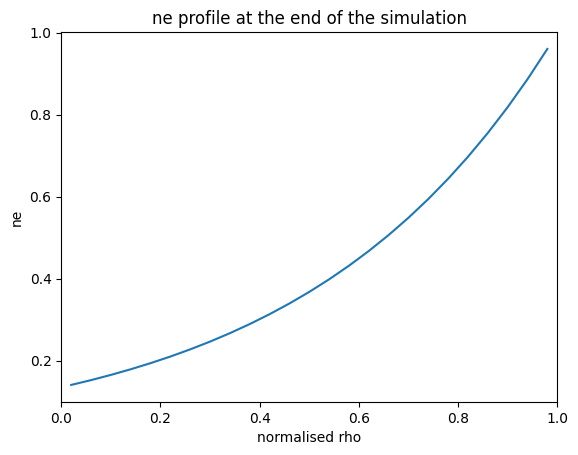

In [3]:
data = load_state_file(output_file)
rho_hats = data.rho_cell_norm.to_numpy()
rho_hats_face = data.rho_face_norm.to_numpy()
ne_sim = data.core_profiles.ne.to_numpy()[-1]
te_sim = data.core_profiles.temp_el.to_numpy()[-1]
ti_sim = data.core_profiles.temp_ion.to_numpy()[-1]
plt.plot(rho_hats, ne_sim)
plt.xlabel('normalised rho')
plt.ylabel('ne')
plt.title('ne profile at the end of the simulation')
plt.xlim(0, 1)
plt.show()

# Equilibrium ODE Solver

This solves for the equilibrium solution, based on the geometrical and transport coefficient profiles.

Note that this won't work for the unmodified version of TORAX, because some of the required profiles are not actually outputted.

In [30]:
def cumulative_integrate(y: jax.Array, x: jax.Array) -> jax.Array:
    return jnp.concatenate([jnp.array([0.0]), 0.5 * (jnp.diff(x) * (y[1:] + y[:-1])).cumsum()])


def reverse_cumulative_integrate(y: jax.Array, x: jax.Array) -> jax.Array:
    """Integrate starting from the end, but return the result in the original order."""


def solve_ode(
        grid: jax.Array,
        a: jax.Array, b: jax.Array, c: jax.Array,
        left_boundary: jax.Array, right_boundary: jax.Array,
        left_boundary_is_grad: bool, right_boundary_is_grad: bool,
) -> tuple[jax.Array, float, float, jax.Array]:
    """Solves an ODE of the form a(x) y' + b(x) y = c(x) + C_1."""
    p = jnp.nan_to_num(b / a, nan=-2)  # TODO: Should this be 0?
    int_p = cumulative_integrate(p, grid)
    mu = jnp.exp(int_p)

    int_mu_over_a = cumulative_integrate(jnp.nan_to_num(mu / a, posinf=0.0), grid)
    int_mu_times_source = cumulative_integrate(jnp.nan_to_num(mu * c / a, nan=0.0, posinf=0.0), grid)

    def ys(c1, c2):
        chex.assert_equal_shape([c1, c2])
        f = lambda c1, c2: c2 / mu + c1 / mu * int_mu_over_a + 1 / mu * int_mu_times_source
        if c1.shape == ():
            return f(c1, c2)
        return jax.vmap(f)(c1, c2)

    def left_boundary_(c1, c2):
        if left_boundary_is_grad:
            return jnp.gradient(ys(c1, c2), grid)[0]
        else:
            return ys(c1, c2)[0]

    def right_boundary_(c1, c2):
        if right_boundary_is_grad:
            return jnp.gradient(ys(c1, c2), grid)[-1]
        else:
            return ys(c1, c2)[-1]

    initial_c1 = jnp.array(0.0)
    initial_c2 = jnp.array(0.0)

    dleft_dc1, dleft_dc2 = jax.grad(left_boundary_, argnums=(0, 1))(initial_c1, initial_c2)
    dright_dc1, dright_dc2 = jax.grad(right_boundary_, argnums=(0, 1))(initial_c1, initial_c2)

    left_change = left_boundary - left_boundary_(initial_c1,  initial_c2)
    right_change = right_boundary - right_boundary_(initial_c1, initial_c2)

    c1, c2 = jnp.linalg.solve(
        jnp.array([[dleft_dc1, dleft_dc2], [dright_dc1, dright_dc2]]),
        jnp.array([left_change, right_change])
    ) + jnp.array([initial_c1, initial_c2])

    residual = a * jnp.gradient(ys(c1, c2), grid) + b * ys(c1, c2) - c - c1

    return ys(c1, c2), c1, c2, residual


vpr = data.vpr.to_numpy()
d_face = data.core_transport.d_face_el.to_numpy()[-1]
v_face = data.core_transport.v_face_el.to_numpy()[-1]
d_cell = (d_face[1:] + d_face[:-1]) / 2
v_cell = (v_face[1:] + v_face[:-1]) / 2
g0 = data.g0.to_numpy()
g1 = data.g1.to_numpy()
g0_face = data.g0_face.to_numpy()
g1_face = data.g1_face.to_numpy()
vpr_face = data.vpr_face.to_numpy()
chie_face = data.core_transport.chi_face_el.to_numpy()[-1]
chii_face = data.core_transport.chi_face_ion.to_numpy()[-1]
chie_cell = (chie_face[1:] + chie_face[:-1]) / 2
chii_cell = (chii_face[1:] + chii_face[:-1]) / 2

ne_source = jnp.zeros_like(rho_hats)
ne_source_integral = cumulative_integrate(ne_source * vpr, rho_hats)
te_source = jnp.zeros_like(rho_hats)
te_source_integral = cumulative_integrate(te_source * vpr, rho_hats)
ti_source = jnp.zeros_like(rho_hats)
ti_source_integral = cumulative_integrate(ti_source * vpr, rho_hats)

ne_left_boundary = 0.0
ne_right_boundary = 1.0
ne_left_boundary_is_grad = True
ne_right_boundary_is_grad = False
te_left_boundary = 0.0
te_right_boundary = 1.0
te_left_boundary_is_grad = True
te_right_boundary_is_grad = False
ti_left_boundary = 0.0
ti_right_boundary = 1.0
ti_left_boundary_is_grad = True
ti_right_boundary_is_grad = False

ne_sol_face, _, _, ne_residual_face = solve_ode(
    rho_hats_face, d_face * jnp.nan_to_num(g1_face / vpr_face, nan=0.0), -g0_face * v_face, jnp.zeros_like(rho_hats_face),
    jnp.array(ne_left_boundary), jnp.array(ne_right_boundary),
    ne_left_boundary_is_grad, ne_right_boundary_is_grad,
)
ne_sol = (ne_sol_face[1:] + ne_sol_face[:-1]) / 2
ni_sol = ne_sol

electron_flux = g0 * v_cell * ne_sim - d_cell * g1 / vpr * jnp.gradient(ne_sim, rho_hats)
ion_flux = electron_flux

te_sol, _, _, te_residual = solve_ode(
    rho_hats, -ne_sol*chie_cell*g1/vpr, 5/2*electron_flux, te_source_integral,
    jnp.array(te_left_boundary), jnp.array(te_right_boundary),
    te_left_boundary_is_grad, te_right_boundary_is_grad,
)

ti_sol, _, _, ti_residual = solve_ode(
    rho_hats, -ni_sol*chii_cell*g1/vpr, 5/2*ion_flux, ti_source_integral,
    jnp.array(ti_left_boundary), jnp.array(ti_right_boundary),
    ti_left_boundary_is_grad, ti_right_boundary_is_grad,
)

plt.plot(rho_hats_face, ne_sol_face)
plt.plot(rho_hats, ne_sim)
plt.legend(['ODE solution', 'TORAX simulation'])
plt.xlabel('normalised rho')
plt.ylabel('ne')
plt.title('ne profile at the end of the simulation')
plt.xlim(0, 1)
plt.show()

plt.plot(rho_hats, te_sol)
plt.plot(rho_hats, te_sim)
plt.legend(['ODE solution', 'TORAX simulation'])
plt.xlabel('normalised rho')
plt.ylabel('te')
plt.title('te profile at the end of the simulation')
plt.xlim(0, 1)
# plt.ylim(0, None)
plt.show()

plt.plot(rho_hats, ti_sol)
plt.plot(rho_hats, ti_sim)
plt.legend(['ODE solution', 'TORAX simulation'])
plt.xlabel('normalised rho')
plt.ylabel('ti')
plt.title('ti profile at the end of the simulation')
plt.xlim(0, 1)
# plt.ylim(0, None)
plt.show()

/tmp/ipykernel_41511/1134314079.py:93: RuntimeWarning: invalid value encountered in divide
  rho_hats_face, d_face * jnp.nan_to_num(g1_face / vpr_face, nan=0.0), -g0_face * v_face, jnp.zeros_like(rho_hats_face),


KeyboardInterrupt: 

In [16]:
d_face * jnp.nan_to_num(g1_face / vpr_face, nan=0.0)

/tmp/ipykernel_41511/3083219521.py:1: RuntimeWarning: invalid value encountered in divide
  d_face * jnp.nan_to_num(g1_face / vpr_face, nan=0.0)


Array([  0.        ,  10.21360354,  21.27311903,  33.17854647,
        45.92988586,  59.5271372 ,  73.97030049,  89.25937573,
       105.39436292, 122.37526206, 140.20207314, 158.87479618,
       178.39343117, 198.75797811, 219.96843699, 242.02480783,
       264.92709061, 288.67528535, 313.26939204, 338.70941067,
       364.99534126, 392.12718379, 420.10493827, 448.92860471,
       478.59818309, 509.11367343], dtype=float64)

In [7]:
"""
D heat: [      0.           23962.68118042   54066.41493662   91346.88166543
  136984.58055649  192323.00912621  258888.96974843  338415.23997997
  432865.8688842   544464.38961061  675725.269461    829488.95286211
 1008960.89039558 1217754.9886693  1459941.96174373 1740103.11548763
 2063390.15210699 2435591.6436936  2863206.89155318 3353527.96293049
 3914730.77924804 4555976.22088038 5287522.31364002 6120848.67247592
 7068794.4993978  8145818.77481269], V heat: [    0.            76.1069777    171.89827307   290.70096364
   436.3012897    613.00103759   825.68053387  1079.86902184
  1381.82327837  1738.61542313  2158.23097625  2649.67833352
  3223.11095276  3889.96368116  4663.10480179  5557.00554144
  6587.92895827  7774.14032661  9136.14134576 10696.93073835
 12482.29405807 14521.12581069 16845.78729923 19492.50394944
 22501.80624047 13054.01556733]
 """

'\nD heat: [      0.           23962.68118042   54066.41493662   91346.88166543\n  136984.58055649  192323.00912621  258888.96974843  338415.23997997\n  432865.8688842   544464.38961061  675725.269461    829488.95286211\n 1008960.89039558 1217754.9886693  1459941.96174373 1740103.11548763\n 2063390.15210699 2435591.6436936  2863206.89155318 3353527.96293049\n 3914730.77924804 4555976.22088038 5287522.31364002 6120848.67247592\n 7068794.4993978  8145818.77481269], V heat: [    0.            76.1069777    171.89827307   290.70096364\n   436.3012897    613.00103759   825.68053387  1079.86902184\n  1381.82327837  1738.61542313  2158.23097625  2649.67833352\n  3223.11095276  3889.96368116  4663.10480179  5557.00554144\n  6587.92895827  7774.14032661  9136.14134576 10696.93073835\n 12482.29405807 14521.12581069 16845.78729923 19492.50394944\n 22501.80624047 13054.01556733]\n '

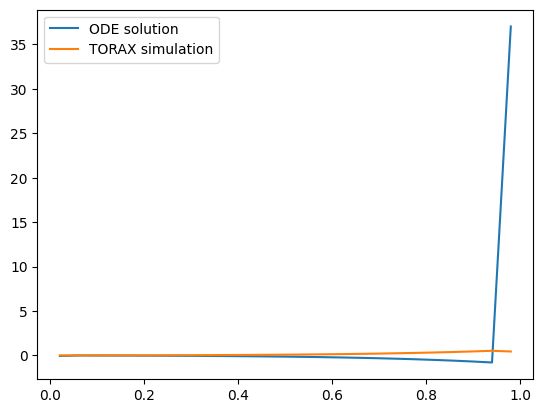

In [8]:
electron_flux_sim = data.post_processed_outputs.flux_ne_face.to_numpy()[-1]
electron_flux_sim = (electron_flux_sim[1:] + electron_flux_sim[:-1]) / 2

plt.plot(rho_hats, electron_flux)
plt.plot(rho_hats, electron_flux_sim)
plt.legend(['ODE solution', 'TORAX simulation'])
plt.show()

In [9]:
electron_flux_sim, electron_flux

(array([0.00095134, 0.00310007, 0.00578249, 0.00908753, 0.01311628,
        0.01798352, 0.02381937, 0.03077115, 0.03900548, 0.04871058,
        0.06009887, 0.07340987, 0.08891343, 0.10691336, 0.12775138,
        0.15181168, 0.17952587, 0.21137852, 0.2479134 , 0.28974031,
        0.33754275, 0.39208641, 0.45422864, 0.52492888, 0.44444777]),
 Array([-5.76973986e-02, -4.59735162e-03, -8.63143602e-03, -1.35927506e-02,
        -1.96321037e-02, -2.69211975e-02, -3.56552510e-02, -4.60559269e-02,
        -5.83745934e-02, -7.28959570e-02, -8.99421076e-02, -1.09877018e-01,
        -1.33111545e-01, -1.60108993e-01, -1.91391292e-01, -2.27545854e-01,
        -2.69233194e-01, -3.17195382e-01, -3.72265421e-01, -4.35377655e-01,
        -5.07579307e-01, -5.90043273e-01, -6.84082311e-01, -7.91164764e-01,
         3.70200729e+01], dtype=float64))

In [10]:
"""
V: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.], D: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.], g0: [   0.           20.42720708   42.54623806   66.35709294   91.85977172
  119.0542744   147.94060098  178.51875146  210.78872583  244.75052411
  280.40414629  317.74959236  356.78686234  397.51595621  439.93687398
  484.04961566  529.85418123  577.3505707   626.53878407  677.41882134
  729.99068251  784.25436758  840.20987655  897.85720942  957.19636618
 1018.22734685], n: [0.14077293 0.14663459 0.15884605 0.17207445 0.18640448 0.20192787
 0.21874402 0.23696057 0.25669415 0.27807111 0.30122828 0.32631393
 0.35348866 0.38292645 0.41481575 0.44936073 0.48678255 0.52732078
 0.57123497 0.61880624 0.67033917 0.72616367 0.78663713 0.85214673
 0.92311185 1.        ], g1: [0.00000000e+00 4.17270789e+02 1.81018237e+03 4.40326378e+03
 8.43821766e+03 1.41739203e+04 2.18864214e+04 3.18689446e+04
 4.44318869e+04 5.99028191e+04 7.86264853e+04 1.00964803e+05
 1.27296865e+05 1.58018935e+05 1.93544453e+05 2.34304030e+05
 2.80745453e+05 3.33333681e+05 3.92550848e+05 4.58896260e+05
 5.32886397e+05 6.15054913e+05 7.05952637e+05 8.06147569e+05
 9.16224883e+05 1.03678693e+06], vpr: [  20.00425111   62.55048917  108.48037503  157.79390869  210.49109015
  266.57191941  326.03639646  388.88452132  455.11629397  524.73171442
  597.73078267  674.11349872  753.87986257  837.02987422  923.56353367
 1013.48084091 1106.78179596 1203.4663988  1303.53464944 1406.98654788
 1513.82209412 1624.04128816 1737.64412999 1854.63061963 1975.00075706], face grad: [0.         0.29308289 0.31749009 0.34392986 0.37257147 0.4035983
 0.43720897 0.47361869 0.51306053 0.55578703 0.60207172 0.65221092
 0.70652564 0.76536361 0.82910153 0.89814745 0.97294342 1.05396831
 1.14174084 1.23682295 1.33982338 1.45140154 1.57227179 1.70320796
 1.84504831 1.99935898]
 """

'\nV: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.\n 1. 1.], D: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.\n 1. 1.], g0: [   0.           20.42720708   42.54623806   66.35709294   91.85977172\n  119.0542744   147.94060098  178.51875146  210.78872583  244.75052411\n  280.40414629  317.74959236  356.78686234  397.51595621  439.93687398\n  484.04961566  529.85418123  577.3505707   626.53878407  677.41882134\n  729.99068251  784.25436758  840.20987655  897.85720942  957.19636618\n 1018.22734685], n: [0.14077293 0.14663459 0.15884605 0.17207445 0.18640448 0.20192787\n 0.21874402 0.23696057 0.25669415 0.27807111 0.30122828 0.32631393\n 0.35348866 0.38292645 0.41481575 0.44936073 0.48678255 0.52732078\n 0.57123497 0.61880624 0.67033917 0.72616367 0.78663713 0.85214673\n 0.92311185 1.        ], g1: [0.00000000e+00 4.17270789e+02 1.81018237e+03 4.40326378e+03\n 8.43821766e+03 1.41739203e+04 2.18864214e+04 3.18689446e+04\n 4.44318869e+04 

In [11]:
jnp.gradient(ne_sol, rho_hats)

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],      dtype=float64)

In [12]:
differences = d_cell * g1 / vpr * jnp.gradient(ne_sol, rho_hats) - g0 * v_cell*ne_sol

In [13]:
differences

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],      dtype=float64)

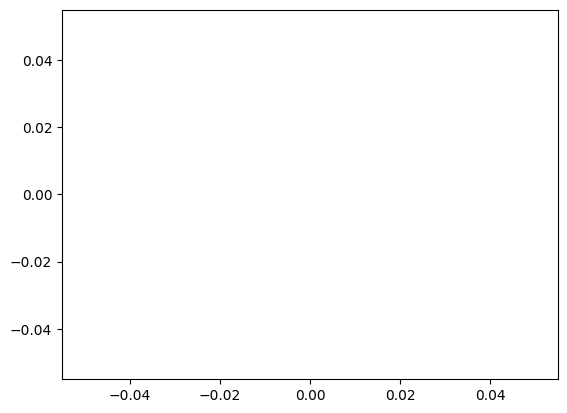

In [14]:
plt.plot(differences)
plt.show()

In [15]:
plt.plot(ne_residual)
plt.ylim(-5, 5)
plt.show()

NameError: name 'ne_residual' is not defined

In [15]:
jnp.gradient(ne_sim, rho_hats)

Array([0.29308289, 0.30528649, 0.33070997, 0.35825066, 0.38808488,
       0.42040363, 0.45541383, 0.49333961, 0.53442378, 0.57892937,
       0.62714132, 0.67936828, 0.73594463, 0.79723257, 0.86362449,
       0.93554544, 1.01345587, 1.09785457, 1.18928189, 1.28832316,
       1.39561246, 1.51183667, 1.63773987, 1.77412813, 1.84504831],      dtype=float64)

In [17]:
te_sol, te_sim

(Array([0.99618071, 0.99618071, 0.99727546, 0.99783842, 0.99815346,
        0.99832641, 0.9984087 , 0.99842916, 0.99840551, 0.99834932,
        0.99826851, 0.99816871, 0.99805402, 0.99792749, 0.99779145,
        0.99764769, 0.9974976 , 0.9973423 , 0.99718267, 0.99701943,
        0.99685316, 0.99668432, 0.99651332, 0.99634048, 1.        ],      dtype=float64),
 array([0.99874318, 0.9988537 , 0.99894913, 0.99903097, 0.99910077,
        0.99916008, 0.99921044, 0.99925338, 0.99929038, 0.99932288,
        0.99935225, 0.9993798 , 0.99940673, 0.99943419, 0.99946318,
        0.99949465, 0.9995294 , 0.99956816, 0.99961153, 0.99966   ,
        0.99971399, 0.99977378, 0.99983957, 0.99991147, 0.99998952]))